In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 6

In [2]:
SPY = pd.read_csv('SPY.csv')
VIX = pd.read_csv('VIX.csv')
RUT = pd.read_csv('RUT.csv')
AAPL = pd.read_csv('AAPL.csv')

In [3]:
def gcd(x_1, x_2):
    """Return greatest common divisor."""
    while x_2:
        x_1, x_2 = x_2, x_1 % x_2
    return x_1


def ks_signif(x_1):
    """
    Return smallest significance level for rejecting null hypothesis,
    using the asymptotic limiting case to compute Q(x) for x > 0.
    """
    if (x_1 <= 0.0):
        return 0.0
    y_1 = 0.0
    for i in range(-20, 20):
        y_1 += math.pow(-1.0, i) * math.exp(-2.0 * i ** 2 * x_1 ** 2)
    return (1.0 - y_1)


def lift(x_1, y_1, buy_threshold=0.0, sell_threshold=0.0, plot=True):
    """
    Construct lift curves and summary statistics for buy and sell targets.
    Baselines are buy_ and sell_ thresholds.

    """
    if (len(x_1) != len(y_1)):
        return 0

    # predictor and target vectors
    data = np.column_stack((x_1, y_1))

    # number of observations = # of rows of data
    nobv = data.shape[0]

    # sort data on predictor (column 0), high to low
    idx = data[:, 0].argsort()[::-1]
    data = data[idx]

    # lift for buy and sell targets
    lift_buy = np.where(data[:, 1] >
                          buy_threshold, 1.0, 0.0).cumsum()
    lift_sell = np.where(data[:, 1][::-1] <
                           sell_threshold, -1.0, 0.0).cumsum()

    # mean lift = (total # of targets in class buy or sell) / nobv
    #meanLiftBuy =  liftBuy[-1] / float(nobv)
    #meanLiftSell = liftSell[-1] / float(nobv)

    # output [column]:
    # [0] buy or sell
    # [1] percent of ordered observations
    # [2] raw lift
    # [3] ratio of lift to mean lift for the percentile
    # [4] number of samples in the percentile

    bins = np.floor(np.sqrt(nobv) + 0.5).astype(int)
    step = int(nobv / bins)
    idx = [np.floor(float(i) / nobv * 100.0 + 0.5) for i in
            range(1, nobv + 1)]

    # zero-pad element 0 of rawLift arrays
    raw_lift_buy = np.insert(
        (np.array([lift_buy[i] / float(i) for i in range(1, nobv)])),
        0, 0.0)
    raw_lift_sell = np.insert(
        (np.array([lift_sell[i] / float(i) for i in range(1, nobv)])),
        0, 0.0)

    print('buy:')
    print('% ordered obs, raw lift, lift/mean lift, # samples')
    for i in range(step - 1, int(nobv/10), step):
        print('{0:.2f} {1:.3f} {2:.3f} {3:3d}'.format(
            idx[i],
            raw_lift_buy[i],
            100.0 *
            (((raw_lift_buy[i] * float(nobv)) / lift_buy[-1]) - 1.0) /
            idx[i],
            i))

    print()

    print('sell:')
    print('% ordered obs, raw lift, lift/mean lift, # samples')
    for i in range(step - 1, int(nobv/10), step):
        print('{0:.2f} {1:.3f} {2:.3f} {3:3d}'.format(
            idx[i],
            raw_lift_sell[i],
            100.0 *
            (((raw_lift_sell[i] * float(nobv)) / lift_sell[-1]) - 1.0) /
            idx[i],
            i))

    # normalize lift by subtracting the cumulative mean lift
    lift_buy -= np.array([lift_buy[-1] / float(nobv)] * nobv).cumsum()
    lift_sell -= np.array([lift_sell[-1] / float(nobv)] * nobv).cumsum()

    if plot:
        plot_lift(lift_buy, data[:, 0], lift_sell, data[:, 0][::-1])
    return


def ks_test(x_1, y_1, plot=True):
    """
    Kolmogorov-Smirnov two-sided, two-sample test.

    Returns tuple of the test statistic for arrays `x` and `y` and
    the significance level for rejecting the null hypothesis.
    The empirical distribution functions F(t) and G(t) are
    computed and (optionally) plotted.

    """
    if (len(x_1) == 0 or len(y_1) == 0):
        return 0
    # rows_x_1, rows_y_1 = # of rows in each array x, y
    rows_x_1 = x_1.shape[0]
    rows_y_1 = y_1.shape[0]

    # compute GCD for (x_1, y_1)
    gcd_x_1_y_1 = float(gcd(rows_x_1, rows_y_1))

    # flatten, concatenate and sort all data from low to high
    data = np.concatenate((x_1.flatten(), y_1.flatten()))
    data = np.sort(data)

    # ECDFs evaluated at ordered combined sample values data.
    f_of_t = np.zeros(len(data))
    g_of_t = np.zeros(len(data))

    # compute j_stat, the K-S statistic.
    j_stat = 0.0
    for i in range(len(data)):
        for j in range(rows_x_1):
            if (x_1[j] <= data[i]):
                f_of_t[i] += 1
        f_of_t[i] /= float(rows_x_1)
        for j in range(rows_y_1):
            if (y_1[j] <= data[i]):
                g_of_t[i] += 1
        g_of_t[i] /= float(rows_y_1)
        j_stat_max = np.abs(f_of_t[i] - g_of_t[i])
        j_stat = max(j_stat, j_stat_max)
    j_stat *= rows_x_1 * rows_y_1 / gcd_x_1_y_1
    # the large-sample approximation
    j_stat_star = j_stat * gcd_x_1_y_1 / np.sqrt(rows_x_1 * rows_y_1 *
                                                 (rows_x_1 + rows_y_1))

    if plot:
        y_2 = np.arange(rows_x_1 + rows_y_1) / float(rows_x_1 + rows_y_1)
        plt.plot(f_of_t, y_2, 'm-', label='F(t)')
        plt.plot(g_of_t, y_2, 'b-', label='G(t)')
        plt.xlabel('value')
        plt.ylabel('cumulative probability')
        plt.rcParams['legend.loc'] = 'best'
        plt.legend()
        plt.text(0.05, 0.05,
                 'Copyright 2012 bicycle trading, llc',
                 fontsize=15, color='gray', alpha=0.6)
        plt.show()
    return '{0:.4f} {1:.4f}'.format(j_stat_star, ks_signif(j_stat_star))


def plot_lift(y_1, y_2, y_3, y_4):
    """Plot normalized lift and sorted predictors."""
    len_y_1 = len(y_1)
    fig = plt.figure()
    p_1 = fig.add_subplot(111)
    arange_y_1 = np.arange(len_y_1)
    p_1.plot(arange_y_1, y_1, 'b-')
    p_1.grid(which='both')
    p_1.minorticks_on()
    p_1.set_xlabel('observations')
    p_1.set_ylabel('normalized lift - buy', color='b')
    for tick in p_1.get_yticklabels():
        tick.set_color('b')
    p_2 = p_1.twinx()
    p_2.plot(y_2, 'b-')
    p_3 = p_1.twinx()
    p_3.plot(y_3, 'r-')
    p_3.set_ylabel('normalized lift - sell', color='r')
    for tick in p_3.get_yticklabels():
        tick.set_color('r')
    p_4 = p_1.twinx()
    p_4.plot(y_4, 'r-')
    yticklabels = p_2.get_yticklabels() + p_4.get_yticklabels()
    yticklines = p_2.get_yticklines() + p_4.get_yticklines()
    plt.setp(yticklabels, visible=False)
    plt.setp(yticklines, visible=False)
#    plt.show()
    return


def roc(x_1, y_1, theta=0.0, plot=True):
    """
    ROC curve plot and statistics.
    """
    if (len(x_1) == 0 or len(y_1) == 0):
        return 0
    # total # of positives and negatives in target
    positives = np.where(y_1 >= theta, 1.0, 0.0).sum()
    negatives = np.where(y_1 < theta, 1.0, 0.0).sum()

    # true positives, false positives rates
    tpr = np.logical_and(np.where(x_1 >= theta, 1.0, 0.0),
                            np.where(y_1 > 0.0, 1.0, 0.0)).astype(float)
    fpr = np.logical_and(np.where(x_1 >= theta, 1.0, 0.0),
                            np.where(y_1 < 0.0, 1.0, 0.0)).astype(float)

    # true positives, false positives, false negatives, true negatives
    tpos = tpr.sum()
    fpos = fpr.sum()
    fneg = positives - tpos
    tneg = negatives - fpos

    # report as fractions
    tpf = tpos / (tpos + fneg)
    fpf = fpos / negatives
    fnf = 1 - tpf
    tnf = tneg / (tneg + fpos)

    # diagnostic likelihood ratios
    dlrp = tpf / fpf
    dlrn = fnf / tnf

    # probability of a positive predictor
    tau = (tpos + fpos) / (positives + negatives)

    # probability of a positive target
    rho = (tpos + fneg) / (positives + negatives)

    # positive predictive value
    ppv = tpos / (tpos + fpos)

    # negative predictive value
    npv = tneg / (tneg + fneg)

    print('threshold: {0:.4f}'.format(theta))
    print()
    print('Classification probabilities on [0, 1]')
    print('FPF: {0:.3f} TPF: {1:.3f} tau (probability of a positive predictor): {2:.3f}'.format(fpf, tpf, tau))
    print()
    print('Predictive values on [0, 1]')
    print('PPV: {0:.3f} NPV: {0:.3f} rho (probability of a positive target): {2:.3f}'.format(ppv, npv, rho))
    print()
    print('Diagnostic likelihood ratios on [0, +oo)')
    print('DLR+: {0:.3f} DLR-: {1:.3f}'.format(dlrp, dlrn))

    if plot:
        pass
        #plt.plot(np.sort(np.asarray(fpr)))
    return

In [4]:
predictor = SPY.Open - SPY.Close.shift(periods=1)  # Today's open - yesterday's close.

predictor.dropna(inplace=True)  # Drop NaNs from the shift operation. Will truncate array by 1 at start of array.

predictor = np.asarray(predictor)  # Make this a numpy array.

target = SPY.Close - SPY.Open  # Today's close - today's open.

target = np.asarray(target)[1:]  # Make this a numpy array, slice to match length of predictor (from start).

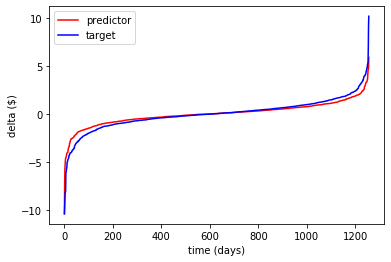

In [5]:
plt.plot(np.sort(predictor), 'r-', label='predictor')
plt.plot(np.sort(target), 'b-', label='target')
plt.ylabel('delta ($)')
plt.xlabel('time (days)')
plt.legend()
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['figure.figsize'] = 8, 6
plt.show()  # A quick look at the distributions.

buy:
% ordered obs, raw lift, lift/mean lift, # samples
3.00 0.559 2.197  34
6.00 0.638 3.606  69
8.00 0.635 2.631 104

sell:
% ordered obs, raw lift, lift/mean lift, # samples
3.00 -0.471 0.372  34
6.00 -0.464 -0.058  69
8.00 -0.510 1.188 104


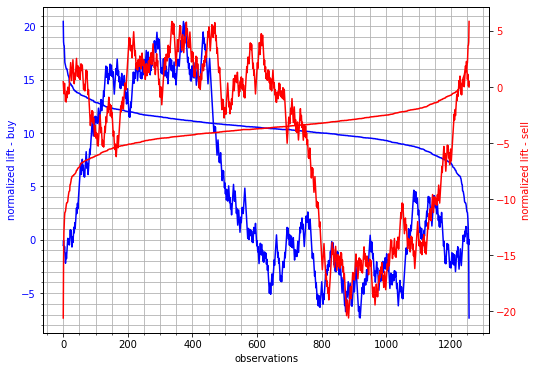

In [6]:
lift(predictor, target)

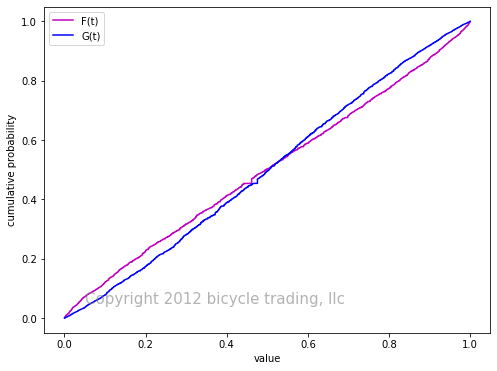

'1.4759 0.0256'

In [217]:
ks_test(predictor, target)

In [222]:
roc(predictor, target, theta=0.0)

threshold: 0.0000

Classification probabilities on [0, 1]
FPF: 0.559 TPF: 0.546 tau (probability of a positive predictor): 0.552

Predictive values on [0, 1]
PPV: 0.529 NPV: 0.529 rho (probability of a positive target): 0.535

Diagnostic likelihood ratios on [0, +oo)
DLR+: 0.977 DLR-: 1.029


In [223]:
predictor = AAPL.Open - AAPL.Close.shift(periods=1)  # Today's open - yesterday's close.

predictor.dropna(inplace=True)  # Drop NaNs from the shift operation. Will truncate array by 1 at start of array.

predictor = np.asarray(predictor)  # Make this a numpy array.

target = SPY.Close - SPY.Open  # Today's close - today's open.

target = np.asarray(target)[1:]  # Make this a numpy array, slice to match length of predictor (from start).

buy:
% ordered obs, raw lift, lift/mean lift, # samples
3.00 0.559 2.197  34
6.00 0.551 0.841  69
8.00 0.587 1.485 104

sell:
% ordered obs, raw lift, lift/mean lift, # samples
3.00 -0.471 0.372  34
6.00 -0.507 1.499  69
8.00 -0.538 1.963 104


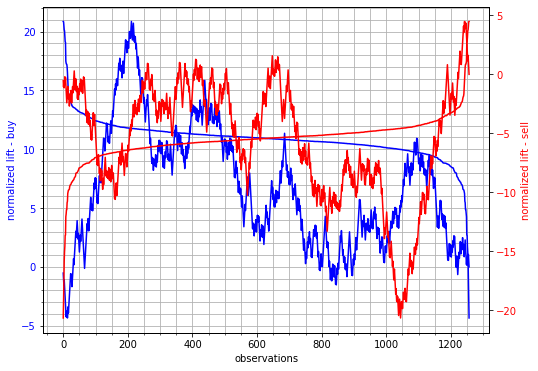

In [224]:
lift(predictor, target)

In [225]:
np.corrcoef(predictor, target)

array([[1.        , 0.03414018],
       [0.03414018, 1.        ]])

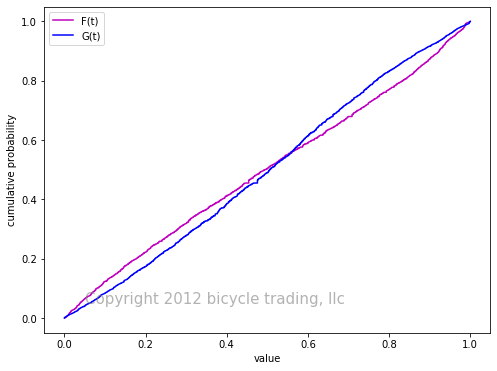

'1.7750 0.0037'

In [226]:
ks_test(predictor, target)

In [227]:
roc(predictor, target)

threshold: 0.0000

Classification probabilities on [0, 1]
FPF: 0.544 TPF: 0.557 tau (probability of a positive predictor): 0.551

Predictive values on [0, 1]
PPV: 0.540 NPV: 0.540 rho (probability of a positive target): 0.535

Diagnostic likelihood ratios on [0, +oo)
DLR+: 1.024 DLR-: 0.972
